## Постановка задачи
Дана выборка независимых одинаково распределенных величин из истинного распределения $x_i \sim p_d(x)$, $i = 1, \dots, N$.

Задача - построить вероятностную модель $p_\theta(x)$ истинного распределения $p_d(x)$.

Распределение $p_\theta(x)$ должно позволять как оценить плотность вероятности для данного объекта $x$, так и сэмплировать $x \sim p_\theta(x)$.

## Вероятностная модель
$z \in \mathbb{R}^d$ - локальная латентная переменная, т. е. своя для каждого объекта $x \in \mathbb{R}^D$.

Генеративный процесс вариационного автокодировщика:
1. Сэмплируем $z \sim p(z)$.
2. $x = G_\theta(z)$.

Параметры преобразования $G_\theta(z)$ задаются нейросетью с весами $\theta$, получающей на вход вектор $z$.

Индуцированная генеративным процессом плотность вероятности объекта $x$:

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z))$$

## Оценка логарифма правдоподобия
Для оценки логарифма правдоподобия используется метод Парзеновского окна/ядерного сглаживания (англ. Kernel Density Estimation/Parzen–Rosenblatt window method). Концептуально он заключается в том, что мы сглаживаем модельное распределение, и по этому сглаженному распределению вычисляем правдоподобие модели.

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z)) \approx \frac{1}{Mh^D}\sum_{i=1}^M K\left(\frac{x - G_\theta(z_i)}{h}\right)$$

Здесь $K(x)$ - любое распределение, а $h$ - ширина окна. Тогда выполняется

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{Mh^D}\sum_{j=1}^M K\left(\frac{x_i - G_\theta(z_j)}{h}\right)$$

В генеративно-состязательных сетях для оценки правдоподобия используется стандартное нормальное распределение $K(x) = N(x | 0, I)$. Тогда получаем

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{M}\sum_{j=1}^M \prod_{k=1}^D\frac{1}{\sqrt{2 \pi} \sigma}\exp\left(-\frac{(x_{i,k} - G(z_j)_k)^2}{2\sigma^2}\right)$$

Коэффициент $\sigma$ настраивается на валидационной выборке и с его помощью считается правдоподобие тестовой выборки.

### Загрузка, нормировка и визуалиация данных

In [1]:
import math
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

ModuleNotFoundError: No module named 'torch'

In [0]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255)
data = MNIST('mnist', download=True, train=False)
test_data_raw = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [0]:
digit_size = 14

In [0]:
train_data.tensors = (nn.AvgPool2d(2, 2)(train_data.tensors[0].view(-1, 28, 28)).data.view(-1, 196), )
test_data_raw.tensors = (nn.AvgPool2d(2, 2)(test_data_raw.tensors[0].view(-1, 28, 28)).data.view(-1, 196), )

In [0]:
valid_data = TensorDataset(test_data_raw.tensors[0][:5000])
test_data = TensorDataset(test_data_raw.tensors[0][5000:])

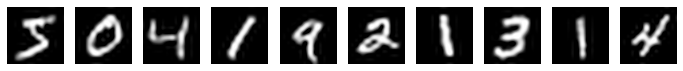

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, digit_size, digit_size)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(train_data[:10][0])

In [0]:
n = 15

from scipy.stats import norm
import numpy as np

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(generator):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])

            x_decoded = generator(z_sample)
            digit = x_decoded
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')
    plt.show()

### Функции и классы, описывающие модель и процесс её обучения

In [0]:
class Reshape(nn.Module):
    def __init__(self, *args):
        """
        Запоминает размерности, в которые при проходе
        вперед будут переводиться все объекты.
        Например,
            input = torch.zeros(100, 196)
            reshape_layer = Reshape(1, 14, 14)
            reshape_layer(input)
        возвращает тензор размерности (100, 1, 14, 14).
            input = torch.zeros(100, 1, 14, 14)
            reshape_layer = Reshape(-1)
            reshape_layer(input)
        наоборот вернет тензор размерности (100, 196).
        """
        super(type(self), self).__init__()
        self.dims = args

    def forward(self, input):
        """
        Возвращает тензор с измененными размерностями объектов.
        Вход: input, FloatTensor.
        Возвращаемое значение: FloatTensor.
        """
        return input.view(input.size(0), *self.dims)

In [0]:
class GAN(nn.Module):
    def __init__(self, d):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        # Можно пробовать другие архитектуры: как более сложные
        # сверточные, так и более простые, например, полносвязные.
        # Однако желательно обучить хотя бы одну сверточную модель.

        first_layer_size = self.d * 8
        if self.d > 8:
            first_layer_size = self.d * 4
        if self.d > 64:
            first_layer_size = self.d * 2
            
        self.discriminator = nn.Sequential(
            Reshape(1, 14, 14),
            nn.Conv2d(1, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, 3, 2, 0, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, 3, 1, 0, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            Reshape(-1),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
        self.generator = nn.Sequential(
            Reshape(self.d, 1, 1),
            nn.ConvTranspose2d(self.d, first_layer_size, 3, 1, 0, 0, bias=False),
            nn.BatchNorm2d(first_layer_size),
            nn.ReLU(),
            nn.ConvTranspose2d(first_layer_size, 64, 2, 1, 0, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2, 1, 0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, 2, 1, 1, bias=False),
            Reshape(-1),
            nn.Sigmoid()
        )

    def generate_noise(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x d.
        """
        z = torch.randn((num_samples, self.d)) / 7
        if next(self.parameters()).is_cuda:
            z = z.cuda()
        return z

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x D.
        """
        z = self.generate_noise(num_samples)
        return self.generator(z)

    def discriminator_loss(self, batch, is_real):
        """
        Вычисляет значение функции потерь дискриминатора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Tensor, скаляр - значение функции потерь
        дискриминатора на данном батче.
        """
        probs = self.discriminator(batch)

        eps_matrix = torch.ones(probs.shape) * 1e-3
        if torch.cuda.is_available():
            eps_matrix = eps_matrix.cuda()
        probs = torch.min(torch.max(eps_matrix, probs), 1 - eps_matrix)

        if is_real:
            return -torch.log(probs).mean()
        return -torch.log(1 - probs).mean()

    def generator_loss(self, batch):
        """
        Вычисляет значение функции потерь генератора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Tensor, скаляр - значение функции потерь
        генератора на данном батче.
        """
        probs = self.discriminator(batch)

        eps_matrix = torch.ones(probs.shape) * 1e-3
        if torch.cuda.is_available():
            eps_matrix = eps_matrix.cuda()   
        probs = torch.min(torch.max(eps_matrix, probs), 1 - eps_matrix)

        return torch.log(1 - probs).mean() - torch.log(probs).mean()

In [0]:
def log_mean_exp(mtx):
    """
    Возвращает логарифм среднего по каждому столбцу от экспоненты данной матрицы.
    Подсказка: не забывайте про вычислительную стабильность!
    Вход: mtx, Tensor - матрица размера n x k.
    Возвращаемое значение: Tensor, вектор длины n.
    """
    max_val, _ = torch.max(mtx, dim=1, keepdim=True)
    return torch.log(torch.mean(torch.exp(mtx - max_val), dim=1)) + max_val.squeeze(1)

In [0]:
sigma_step = 100 ** 0.05

In [0]:
def log_likelihood(generated_set, validation_set, test_set):
    """
    Возвращает оценку логарифма правдоподобия модели GAN методом
    Парзеновского окна со стандартным нормальным ядром.
    Подсказка: sigma должна настраиваться по валидационной выборке, а
    правдоподобие считаться по тестовой.
    Подсказка: вместо sigma можно настраивать log_sigma.
    Подсказка: для настойки sigma допустимо использовать как перебор по сетке,
    так и другие методы опимизации.
    Вход: generated_set - сэмплы из генеративной модели.
    Вход: validation_set - валидационная выборка.
    Вход: test_set - тестовая выборка.
    Возвращаемое значение: float (не Tensor!) - оценка логарифма правдоподобия.
    """
    sigmas = np.logspace(math.log(0.1, sigma_step), math.log(10, sigma_step),
                         num=20, base=sigma_step)
    max_val = -float('inf')
    opt_sigma = 0.1

    for sigma in sigmas:
        a, b = validation_set.unsqueeze(1), generated_set.unsqueeze(0)
        difference = 0
        for i in range(generated_set.shape[1]):
            difference -= (((a[:,:,i] - b[:,:,i]) / sigma) ** 2) / 2
        for_exp = difference - (1/2 * math.log(math.pi) + math.log(sigma)) * generated_set.shape[1]
        log_prob = log_mean_exp(for_exp).mean()
        if float(log_prob) > max_val:
            max_val = log_prob
            opt_sigma = sigma
            
    a, b = test_set.unsqueeze(1), generated_set.unsqueeze(0)
    difference = 0
    for i in range(generated_set.shape[1]):
        difference -= (((a[:,:,i] - b[:,:,i]) / opt_sigma) ** 2) / 2
    for_exp = difference - (1/2 * math.log(math.pi) + math.log(opt_sigma)) * generated_set.shape[1]
    return log_mean_exp(for_exp).mean()

In [0]:
def generate_many_samples(model, num_samples, batch_size):
    size = 0
    res = []
    while size < num_samples:
        res.append(model.generate_samples(min(batch_size, num_samples - size)))
        size += batch_size
    return torch.cat(res, 0)

In [0]:
def train_model(model, num_epochs=100, learning_rate=2e-4, batch_size=64, k=1):
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: k, int - число итераций оптимизации дискриминатора на итерацию оптимизации
    генератора.
    Вход: batch_size, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'generator_losses' - список значений функции потерь генератора,
    'discriminator_losses' - список значений функции потерь дискриминатора.
    """
    if torch.cuda.is_available():
        model = model.cuda()
    model.train()

    # возможно, нужно использовать другие методы оптимизации или параметры методов оптимизации,
    # чтобы модель обучилась
    gd_generator = optim.Adam(model.generator.parameters(), lr=learning_rate, betas=(0.3, 0.999))
    gd_discriminator = optim.RMSprop(model.discriminator.parameters(), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    total_batches = len(dataloader)

    generator_losses = [0]
    discriminator_losses = [0]
    log_likelihoods = []

    generated_samples = generate_many_samples(model, 512, batch_size).detach()
    valid_samples = valid_data[np.random.choice(len(valid_data), 512, False)][0]
    valid_samples = valid_samples.to(next(model.parameters()).device)
    test_samples = test_data[np.random.choice(len(test_data), 512, False)][0]
    test_samples = test_samples.to(next(model.parameters()).device)
    ll = log_likelihood(generated_samples, valid_samples, test_samples)
    log_likelihoods.append(ll)
    print('Log-likelihood', ll, flush=True)

    for epoch in range(num_epochs):
        for i, (batch, ) in enumerate(dataloader):
            if torch.cuda.is_available():
                batch = batch.cuda()
            
            for _ in range(k):
                gd_discriminator.zero_grad()
                gd_generator.zero_grad()                  
                samples = model.generate_samples(batch.shape[0])
                discr_loss = model.discriminator_loss(batch, True) + model.discriminator_loss(samples, False)
                discr_loss.backward(retain_graph=True)
                gd_discriminator.step() 


            gd_discriminator.zero_grad()
            gd_generator.zero_grad()
                      
            samples = model.generate_samples(batch.shape[0])
            gen_loss = model.generator_loss(samples)
            gen_loss.backward()
            gd_generator.step()

            # не забудьте корректно сохранить статистику
            discriminator_losses.append(float(discr_loss))
            generator_losses.append(float(gen_loss))

            if (i + 1) % 100 == 0:
                print('\rEpoch:', epoch, 'G_loss:', generator_losses[-1],
                      'D_loss:', discriminator_losses[-1],
                      'Batch', i + 1, 'of', total_batches,
                      ' ' * 10, end='', flush=True)
        print(flush=True)
        generated_samples = generate_many_samples(model, 512, batch_size).detach()
        valid_samples = valid_data[np.random.choice(len(valid_data), 512, False)][0]
        valid_samples = valid_samples.to(next(model.parameters()).device)
        test_samples = test_data[np.random.choice(len(test_data), 512, False)][0]
        test_samples = test_samples.to(next(model.parameters()).device)
        ll = log_likelihood(generated_samples, valid_samples, test_samples)
        log_likelihoods.append(ll)
        print('Log-likelihood', ll, flush=True)

    return {
        'model': model.cpu(),
        'generator_losses': generator_losses,
        'discriminator_losses': discriminator_losses,
        'log_likelihoods': log_likelihoods
    }

### Обучение модели

In [0]:
# Подсказка: обучать GANs с скрытой размерностью 2 непросто,
# для этого требуется очень аккуратно подобрать хаки/процесс обучения/
# /архитектуру модели/инициализацию.
# Если не получается сразу, стоит обучить GANs с бОльшей скрытой размерностью,
# а затем вернуться к этой ячейке.
g2 = GAN(2)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d2 = train_model(g2, num_epochs=15, batch_size=128, learning_rate=4e-4)

Log-likelihood tensor(-67.8911, device='cuda:0')
Epoch: 0 G_loss: 0.24303126335144043 D_loss: 1.2190707921981812 Batch 400 of 469           
Log-likelihood tensor(14.7540, device='cuda:0')
Epoch: 1 G_loss: 0.15146929025650024 D_loss: 1.3013958930969238 Batch 400 of 469           
Log-likelihood tensor(67.7242, device='cuda:0')
Epoch: 2 G_loss: 0.2290056347846985 D_loss: 1.2737113237380981 Batch 400 of 469           
Log-likelihood tensor(79.9725, device='cuda:0')
Epoch: 3 G_loss: 0.29320281744003296 D_loss: 1.217560887336731 Batch 400 of 469           
Log-likelihood tensor(71.4234, device='cuda:0')
Epoch: 4 G_loss: 0.342609167098999 D_loss: 1.226337194442749 Batch 400 of 469           
Log-likelihood tensor(77.5110, device='cuda:0')
Epoch: 5 G_loss: 0.37526047229766846 D_loss: 1.1725246906280518 Batch 400 of 469           
Log-likelihood tensor(77.4412, device='cuda:0')
Epoch: 6 G_loss: 0.39137595891952515 D_loss: 1.2218912839889526 Batch 400 of 469           
Log-likelihood tensor(73

In [0]:
g10 = GAN(10)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d10 = train_model(g10, num_epochs=40)

Log-likelihood tensor(-60.8112, device='cuda:0')
Epoch: 0 G_loss: 0.13492423295974731 D_loss: 1.2678215503692627 Batch 900 of 938           
Log-likelihood tensor(8.6169, device='cuda:0')
Epoch: 1 G_loss: 0.127139151096344 D_loss: 1.287276268005371 Batch 900 of 938           
Log-likelihood tensor(96.2556, device='cuda:0')
Epoch: 2 G_loss: 0.1450868844985962 D_loss: 1.310828685760498 Batch 900 of 938           
Log-likelihood tensor(106.3546, device='cuda:0')
Epoch: 3 G_loss: 0.11713898181915283 D_loss: 1.2912341356277466 Batch 900 of 938           
Log-likelihood tensor(107.8753, device='cuda:0')
Epoch: 4 G_loss: 0.03946244716644287 D_loss: 1.3438388109207153 Batch 900 of 938           
Log-likelihood tensor(111.4992, device='cuda:0')
Epoch: 5 G_loss: 0.12895286083221436 D_loss: 1.3424968719482422 Batch 900 of 938           
Log-likelihood tensor(111.5674, device='cuda:0')
Epoch: 6 G_loss: 0.13073712587356567 D_loss: 1.3759504556655884 Batch 900 of 938           
Log-likelihood tensor

In [0]:
g100 = GAN(100)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d100 = train_model(g100, num_epochs=50)

Log-likelihood tensor(-77.7088, device='cuda:0')
Epoch: 0 G_loss: 0.16228830814361572 D_loss: 1.2572808265686035 Batch 900 of 938           
Log-likelihood tensor(28.6307, device='cuda:0')
Epoch: 1 G_loss: 0.1575939655303955 D_loss: 1.2637901306152344 Batch 900 of 938           
Log-likelihood tensor(93.3973, device='cuda:0')
Epoch: 2 G_loss: 0.08117389678955078 D_loss: 1.2622582912445068 Batch 900 of 938           
Log-likelihood tensor(103.3252, device='cuda:0')
Epoch: 3 G_loss: 0.16830933094024658 D_loss: 1.2850204706192017 Batch 900 of 938           
Log-likelihood tensor(106.2409, device='cuda:0')
Epoch: 4 G_loss: 0.2515244483947754 D_loss: 1.2498698234558105 Batch 900 of 938           
Log-likelihood tensor(104.9670, device='cuda:0')
Epoch: 5 G_loss: 0.26369786262512207 D_loss: 1.2524335384368896 Batch 900 of 938           
Log-likelihood tensor(113.1909, device='cuda:0')
Epoch: 6 G_loss: 0.33043497800827026 D_loss: 1.5484309196472168 Batch 900 of 938           
Log-likelihood te

### Обучение модели

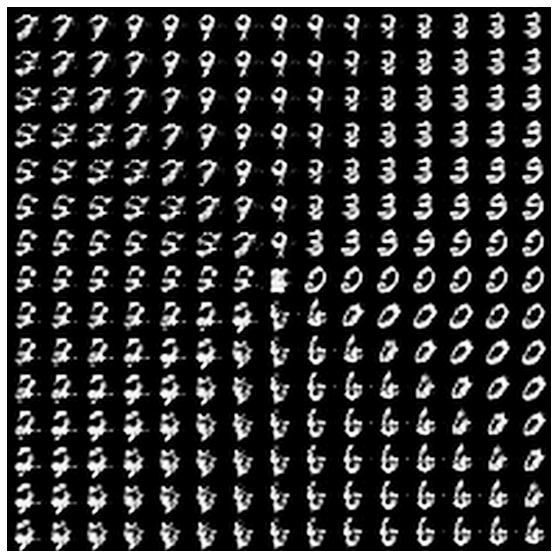

In [0]:
def draw_manifold_gan(model):
    generator = lambda z: model.generator(torch.from_numpy(z).float()).view(digit_size, digit_size).data.numpy()
    return draw_manifold(generator)

draw_manifold_gan(gan_model_d2['model'])

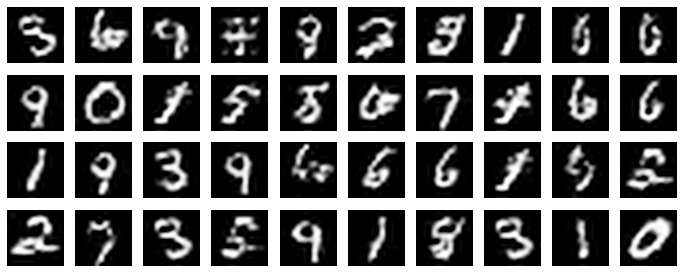

In [0]:
show_images(gan_model_d2['model'].generate_samples(40))

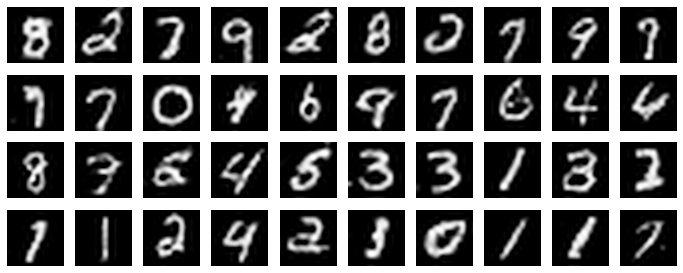

In [0]:
show_images(gan_model_d10['model'].generate_samples(40))

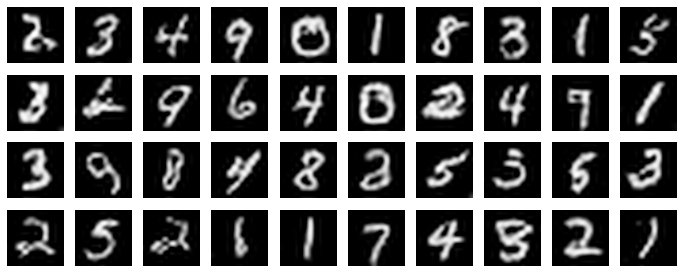

In [0]:
show_images(gan_model_d100['model'].generate_samples(40))

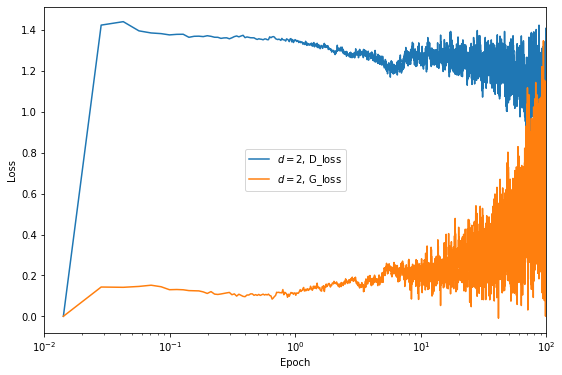

In [0]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, D_loss', 'discriminator_losses', gan_model_d2),
    ('$d = 2$, G_loss', 'generator_losses', gan_model_d2),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

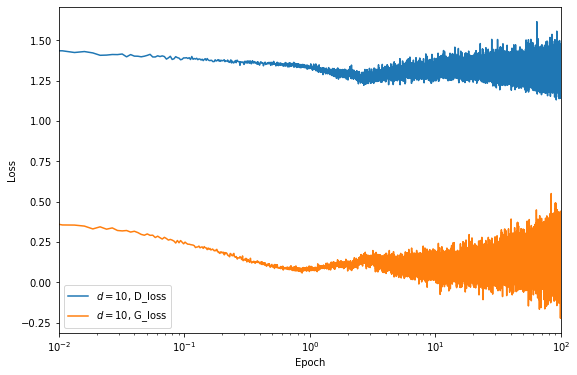

In [0]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 10$, D_loss', 'discriminator_losses', gan_model_d10),
    ('$d = 10$, G_loss', 'generator_losses', gan_model_d10),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

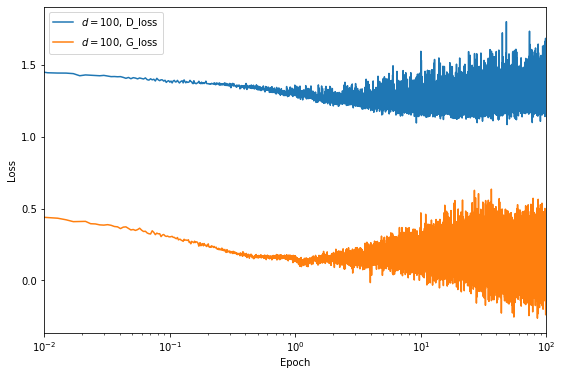

In [0]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 100$, D_loss', 'discriminator_losses', gan_model_d100),
    ('$d = 100$, G_loss', 'generator_losses', gan_model_d100),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

In [0]:
generated_samples = generate_many_samples(gan_model_d2['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

CPU times: user 13min 35s, sys: 13.9 s, total: 13min 49s
Wall time: 13min 50s


tensor(106.1408)

In [0]:
generated_samples = generate_many_samples(gan_model_d10['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

CPU times: user 14min 8s, sys: 12.9 s, total: 14min 21s
Wall time: 14min 22s


tensor(157.5520)

In [0]:
generated_samples = generate_many_samples(gan_model_d100['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

CPU times: user 14min 13s, sys: 13 s, total: 14min 26s
Wall time: 14min 26s


tensor(163.4464)

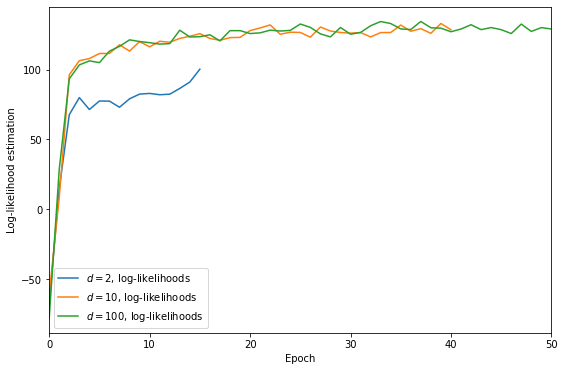

In [0]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, log-likelihoods', 'log_likelihoods', gan_model_d2),
    ('$d = 10$, log-likelihoods', 'log_likelihoods', gan_model_d10),
    ('$d = 100$, log-likelihoods', 'log_likelihoods', gan_model_d100)
]:
    data = model[name]
    x_labels = np.arange(len(data))
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.0, xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation')
plt.legend()
pass

## Выводы
Место для ваших выводов, наблюдений, гипотез.

Оценка правдоподобия для генерируемых сэмплов при $d = 10$ и $d = 100$ возрастает в начале обучения и выходит на асимптоту. Ошибки дискриминатора и генератора, несмотря на достаточно значительные колебания, в среднем достаточно стабильны. При $d = 2$ слишком большое число эпох обучения может привести к тому, что ошибка дискриминатора стремится к нулю, что коррелирует с крайне низким качеством генерируемых изображений (вплоть до почти полностью черных квадратов). Поэтому для этого случая выбрано небольшое (15) число эпох, также для более стабильного результата были реализованы следующие изменения (возможно, не все они точно полезны, но, как кажется, результат улучшился):

- в генератор добавлен дополнительный ConvTranspose2d-слой, также несколько изменены размеры слоев сети (по интуитивным соображениям);

- модифицирована функции ошибки генератора (https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/, "Flip the labels and loss function when training the generator");

- слишком малые/большие вероятности перед логарифмированием при подсчете кросс-энтропии заменяются на $\varepsilon$ и $1 - \varepsilon$ соответственно;

- еще уменьшена $\beta_1$ в Adam;

- изменена на 0.2 константа для LeakyReLU (https://arxiv.org/abs/1511.06434, найдено на том же сайте)

Обучить модель генерировать хорошие сэмплы из латентного пространства малой размерности ($d = 2$) действительно непросто, наверно поэтому ошибка дискриминатора может стремиться к нулю, так как он (в плохом случае) легко отличает реальные изображения от сгенерированных, а генератор, в свою очередь, может настраиваться на "тривиальный" дискриминатор и не выучить ничего полезного, поскольку все взаимосвязанно.